# Simon's Algorithm

## Background

**Usage estimate:** The estimated runtime of Simon’s algorithm is approximately **10–15 seconds** for $n = 4$ qubits on a typical quantum backend. Actual runtimes may vary depending on backend load, qubit coherence times, and network latency when using cloud-based quantum services.

To run **Simon’s Algorithm**, we require:

- An **oracle** that implements a *two-to-one* function with a hidden bitstring $s \in \{0,1\}^n$, such that:
  
  $$
  \forall x \in \{0,1\}^n,\quad f(x) = f(x \oplus s)
  $$

- A quantum circuit that:
  1. Creates a uniform superposition over all inputs using Hadamard gates.
  2. Applies the oracle (as a unitary gate $U_f$).
  3. Applies Hadamard gates again to the first register.
  4. Measures the first register to extract bitstrings orthogonal to $s$ (i.e., $y \cdot s = 0 \mod 2$).

The **oracle** can be constructed using custom gate definitions or controlled permutations that encode the two-to-one function. In practice, oracles are hand-coded to reflect specific function mappings that satisfy the Simon promise.

You can use the [`Sampler`](https://docs.quantum.ibm.com/api/qiskit/primitive/sampler) primitive from Qiskit Runtime or a local simulator like `AerSimulator` to execute the circuit. Multiple independent runs are required to collect $n$ linearly independent measurement results. These are then solved classically (over $\mathbb{F}_2$) to recover the hidden string $s$.

Simon’s algorithm provides an exponential speedup over classical methods, solving the problem in $\mathcal{O}(n)$ queries as opposed to $\mathcal{O}(2^{n/2})$ in the classical probabilistic case.


### Requirements
Before starting this tutorial, ensure that the following dependencies are installed:
- Qiskit SDK 1.0 or later, with visualization support \texttt{pip install 'qiskit[visualization]'}
- Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later

## Setup
Here we import the small number of tools we need for this tutorial

In [40]:
#Built-in modules
import math
import sympy
from sympy import Matrix
from typing import Dict
import numpy as np

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

#Imports from Qiskit Primitives
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService

In [30]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = AerSimulator()  # Use AerSimulator for local simulation

# To run on IBM Quantum hardware, uncomment the following lines
# service = QiskitRuntimeService(channel="ibm_cloud")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

## Step 1: Map classical inputs to a quantum problem

Simons algorithm is a quantum algorithm for solving the problem of finding a hidden binary string \( s \) such that \( f(x) = f(y) \) if and only if \( x \oplus y = s \). The algorithm is efficient for certain classes of functions, particularly those that are periodic. Here, we demonstrate how to construct the oracle for a specific function and use the gates from the Qiskit circuit library to set up a Simon's circuit.

We use runtime Sampler primitive to execute the Simon's circuit.

In [31]:
def simon_circuit(oracle):
    # Create a Quantum Circuit
    qubits=QuantumRegister(oracle.num_qubits,name="q")
    cbits=ClassicalRegister(oracle.num_qubits//2,name="c")
    circuit=QuantumCircuit(qubits,cbits)

    # Apply Hadamard gates to the first n qubits
    circuit.h(qubits[:oracle.num_qubits//2])
    circuit.append(oracle, qubits)
    circuit.h(qubits[:oracle.num_qubits//2])
    # Measure the first n qubits
    circuit.measure(qubits[:oracle.num_qubits//2], cbits)
    # Set the name of the circuit
    circuit.name = 'Simon\'s Algorithm Circuit'

    return circuit

def build_oracle(f_dict: Dict[str, str]) -> QuantumCircuit:
    """
    Builds a classical reversible oracle U_f: |x⟩|y⟩ ↦ |x⟩|y ⊕ f(x)⟩
    
    Args:
        f_dict (Dict[str, str]): Mapping from binary strings to binary strings.
        
    Returns:
        QuantumCircuit: The oracle circuit.
    """

    def bitstring_to_bitlist(s: str) -> list[int]:
        return [int(b) for b in s]

    # Determine input/output width
    n_in = len(next(iter(f_dict)))
    n_out = len(next(iter(f_dict.values())))

    # Registers
    q_in = QuantumRegister(n_in, name='q_in')
    q_out = QuantumRegister(n_out, name='q_out')
    oracle = QuantumCircuit(q_in, q_out, name='Oracle')

    # Construct the oracle
    for x_str, f_str in f_dict.items():
        x_bits = bitstring_to_bitlist(x_str)
        f_bits = bitstring_to_bitlist(f_str)

        # Apply X to invert controls where bit is 0
        for i, bit in enumerate(x_bits):
            if bit == 0:
                oracle.x(q_in[i])

        # Apply MCX to encode f(x) as y ⊕ f(x)
        for j, fbit in enumerate(f_bits):
            if fbit == 1:
                oracle.mcx(q_in[:], q_out[j])

        # Uncompute the control X gates
        for i, bit in enumerate(x_bits):
            if bit == 0:
                oracle.x(q_in[i])

    return oracle

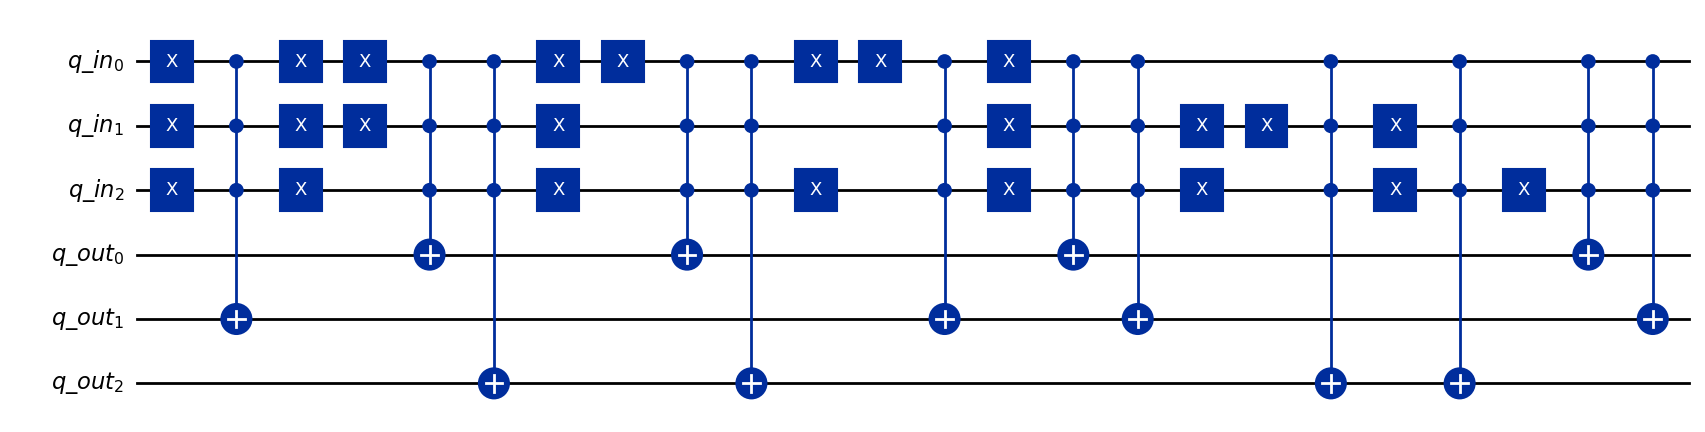

In [32]:
# Define mapping as dict: x -> f(x)
f = {
    '000': '010',
    '001': '101',
    '010': '101',
    '011': '010',
    '100': '110',
    '101': '001',
    '110': '001',
    '111': '110'
}

oracle = build_oracle(f)
oracle.draw('mpl')


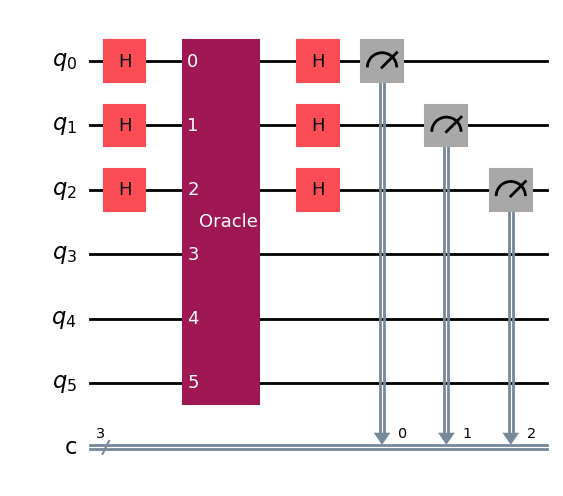

In [33]:
qc = simon_circuit(build_oracle(f))
qc.draw(output="mpl")

## Step 2: Optimize problem for quantum execution

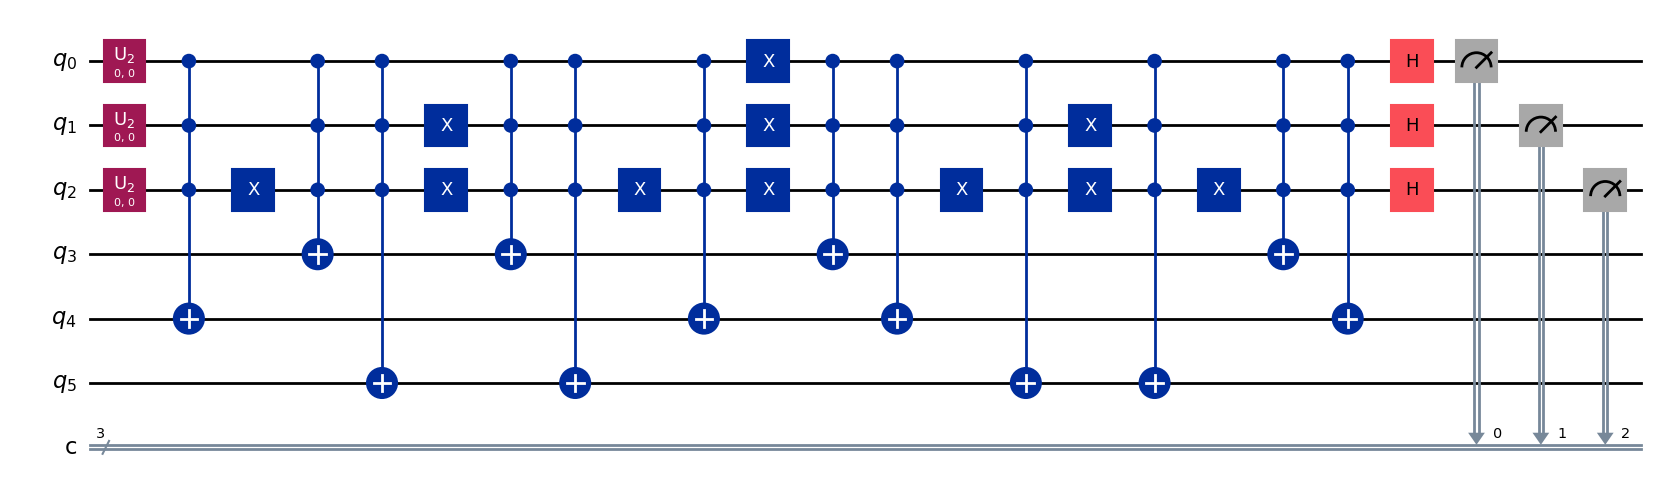

In [34]:
target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa_qc=pm.run(qc)
circuit_isa_qc.draw(output="mpl",idle_wires=False,style="iqp")

## Step 3: Execute using Qiskit Primitives

We are now required to run the circuit and sample the measurements on th first qubit thus for execution we will use the Sampler runtime primitive.

In [35]:
sampler=Sampler(mode=backend)
sampler.options.default_shots=10_000
result = sampler.run([circuit_isa_qc]).result()
dist = result[0].data.c.get_counts()

## Step 4: Post-process results

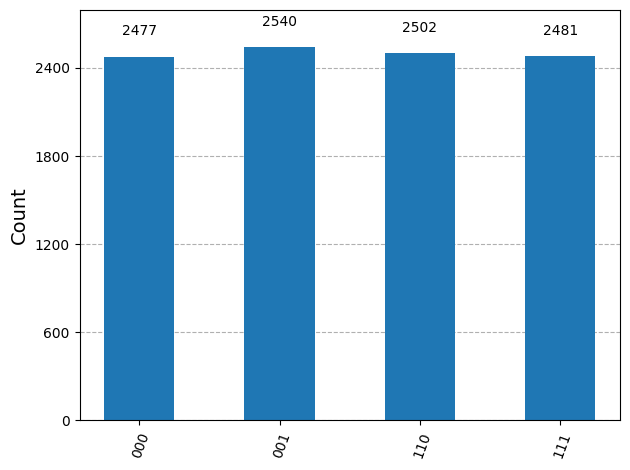

In [36]:
plot_histogram(dist)

In [37]:
# Revese the bit order in the keys
dist_reversed = {key[::-1]: value for key, value in dist.items()}
#Pick the top 4 keys
top_keys = sorted(dist_reversed, key=dist_reversed.get, reverse=True)[:3]
print("Top 4 keys:", top_keys)

Top 4 keys: ['100', '011', '111']


In [38]:
# Step 1: Create binary matrix from strings
matrix = np.array([list(map(int, key)) for key in top_keys])
print("Matrix from top keys:")
print(matrix)

# Step 2: Convert to sympy Matrix and reduce mod 2
A = Matrix(matrix)
A_mod2 = A.applyfunc(lambda x: x % 2)

# Step 3: Compute nullspace over GF(2)
nullspace = A_mod2.nullspace(iszerofunc=lambda x: x % 2 == 0)

# Step 4: Convert each sympy vector to numpy array with mod 2
nullspace_numpy = [np.array(vec.applyfunc(lambda x: x % 2)).astype(int).flatten() for vec in nullspace]

# Output
print("\nNullspace basis vectors over GF(2) (as numpy arrays):")
for vec in nullspace_numpy:
    print(vec)


Matrix from top keys:
[[1 0 0]
 [0 1 1]
 [1 1 1]]

Nullspace basis vectors over GF(2) (as numpy arrays):
[0 1 1]


In [39]:
# Convert each nullspace basis vector to a bit string
bit_strings = [''.join(map(str, vec)) for vec in nullspace_numpy]
string = ''.join(bit_strings)
print("The string is s:",string)

The string is s: 011
